# Exercises - Week 5 - Model Assesment
#### Simon Lee, BIO-322, Machine Learning for Bioengineers, Winter 2022

## Conceptual
#### Exercise 1
We review k-fold cross-validation.
- Explain how k-fold cross-validation is implemented.
- What are the advantages and disadvantages of k-fold cross-validation relative to:
    - The validation set approach?
    - LOOCV?

#### Solution

* k-fold cross validation is implemented by randomly splitting the data set into $k$ non-overlapping subsets (folds), each with approximately equal size. The model is now trained on all data points in ($k-1$) folds, while the test error is estimated using the data points in the one remaining fold which is reservered for validation. We perform this fitting procedure $k$ times, each time reserving a different fold for validation. This finally results in $k$ estimates of the test error, which we average to yield our final cross-validation test error estimate. This can then be used to compare different models.
* The validation set approach has two main drawbacks compared to k-fold cross-validation. First, the validation estimate of the test error rate can be highly variable (depending on precisely which observations are included in the training set and which observations are included in the validation set). Second, only a subset of the observations are used to fit the model, and the training set is typically smaller in the validation set approach than in k-fold CV. Because statistical methods tend to perform worse when trained on fewer observations, this suggests that the validation set test error will be higher than the test error for k-fold CV.
* Leaf-one-out cross-validation (LOOCV) is a special case of k-fold cross-validation in which $k = n$. Like k-fold CV tends to have a lower estimate of the test error than the validation set approach because the training sets are larger, LOOCV tends to have an even better estimate of the training error, as it uses the largest possible training set. (Side remark: In some cases LOOCV can have a larger variance than k-fold cross-validation, because the training sets are very similar to each other and averages of correlated numbers tend to have higher variance than averages of uncorrelated numbers; see Chapter 5.1.4 of the Introduction to Statistical Learning, Second Edition and e.g. [here](https://stats.stackexchange.com/questions/223446/variance-of-the-mean-of-correlated-and-uncorrelated-data) and [here](https://stats.stackexchange.com/questions/61783/bias-and-variance-in-leave-one-out-vs-k-fold-cross-validation/244112#244112)). LOOCV has one main drawbacks compared to k-fold cross-validation. It requires fitting the potentially computationally expensive model $n$ times compared to k-fold cross-validation which requires the model to be fitted only $k$ times (where typically $k \\ll n$). .

#### Exercise 2
You are given a model with unknown hyper-parameters and the goal is to find the optimal hyper-parameters and estimate the test error of the optimal model. Suppose of colleague of yours argues that this should be done in the following way: \"Take all the data and run cross-validation to find the best hyper-parameters. Taking all data is better, than taking only a subset, because one has more data to estimate the parameters and estimate the test error on the validation sets. Once the best hyper-parameters are found: estimate the test error by running again cross-validation on all the data with the hyper-parameter fixed to the best value.\" Do you agree with your colleague? If not, explain where you disagree and where you agree.


#### Solution

Your colleague is right that "taking all data is better, than taking only a subset, because one has more data to estimate the parameters and estimate the test error on the validation sets."
However, it is not a good idea to use the same data (that was used for hyper-parameter tuning) to estimate the test error. Suppose the data is such that different values for the hyper-parameters would be found for different folds in a nested cross-validation. In this case, the hyper-parameters found with cross-validation on the full data set are particular to the full data set, i.e. they slighly overfit the full data set. Estimating the test error on the same data set will thus lead to a test error estimate that is slightly too small. If we want a better estimate of the test error, we should use nested cross-validation.

#### Exercise 3
Suppose you receive the following email of a colleague of yours. Write an answer to this email.
```
    Hi
    In my internship I am doing this research project with a company that
    manufactures constituents for medical devices. We need to assure high
    quality and detect the pieces that are not fully functional. To do so we
    perform 23 measurements on each piece. My goal is to find a machine
    learning method that detects defective pieces automatically. Both, my
    training set and my test set consist of 4000 pieces that were fine and
    30 defective ones.  I ran logistic regression on that data and found a
    training error of 0.1% and a test error of 0.3%, which is already pretty
    good, I think, no? But with kNN classification it is even better. For
    k = 7 I found a test error of 0.05% which is by far lower than all test
    errors I obtained with other values of k. I was really impressed. Now
    we have a method that predicts with 99.95% accuracy whether a piece is
    defective or not!
    Because you are taking this machine learning class now, I wanted to ask you
    for advice. Does it all make sense to you what I described? If not, do you
    have any suggestion to get even better results?
    Ã bientôt
    Jamie
```

#### Solution

Here is what I think about your approach.

1. Because there are many more functional than defective pieces it is easy to get low error rates. In fact, if a machine classifies all pieces as functional it will make only 30 mistakes out of 4030 cases, which means an error rate of 0.74%. That is, a machine that does not detect any defective piece will have an error rate of less than 1%! Therefore I would say a test error rate of 0.3% is not good.
2. Rather than looking at the error rate (I suppose you look at the error rate for decision threshold 0.5) I would suggest to look at the confusion matrix. You should look in particular at the false positive rate (i.e. those pieces that are classified as functional although they are defective). Maybe you want to choose another decision threshold to have basically zero false positives. I guess the false negatives would be less problematic. Maybe somebody could even have a second look at the pieces that are classified as defective and decide manually whether some of them are still functional.
3. You seem to have taken a validation set approach to finding the optimal k, for kNN classification. I would suggest to use cross-validation, because it finds the optimal k much more reliably than the validation set approach.
4. I don't think that kNN with k = 7 really has 99.95% accuracy on held-out test data. You used your test set as a validation set to find the optimal value for the hyper-parameter k. The best validation error can be substantially lower than the true test error. If you really want to estimate the test error, I would
    i) perform cross-validation on a subset of the data to find the hyper-parameters
    ii) once the optimal hyper-parameter is found, refit the model on the whole subset
    iii) estimate the test error with this model on a test set that was never touched before.

## Applied
#### Exercise 4
Take the `classification_data` in our notebook on
   \"flexibility and bias-variance-decomposition notebook\" and find with 10-fold
   cross-validation the optimal number $k$ of neighbors of kNN
   classification, using the AUC measure. Hint: `MLJ` has the builtin function `auc`.
   Plot the validation AUC for $k = 1, \ldots, 50$.

In [1]:
begin
    using Pkg
    Pkg.activate(joinpath(Pkg.devdir(), "MLCourse"))
    using CSV, DataFrames, MLJ, MLJLinearModels, NearestNeighborModels, MLCourse, Random, Plots
	import MLCourse: Polynomial
end

  Activating project at `~/.julia/dev/MLCourse`


In [2]:
begin
    f(x) = .3 * sin(10x) + .7x
	σ(x) = 1 / (1 + exp(-x))
    function classification_data_generator(; n, rng = Random.GLOBAL_RNG)
        X1 = rand(rng, n)
        X2 = rand(rng, n)
        df = DataFrame(X1 = X1, X2 = X2,
                       y = σ.(20(f.(X1) .- X2)) .> rand(rng, n))
        coerce!(df, :y => Multiclass)
    end
end;

In [3]:
classification_data = classification_data_generator(n = 400, rng = MersenneTwister(8))

,X1,X2,y
,Float64,Float64,Cat…
1,0.0123577,0.4356,false
2,0.894287,0.296015,true
3,0.880851,0.27181,true
4,0.769253,0.450788,true
5,0.854293,0.706722,true
6,0.335856,0.832105,false
7,0.517338,0.542124,false
8,0.0455585,0.828993,false
9,0.612485,0.643947,false


In [4]:
begin
    model = KNNClassifier()
    self_tuning_model = TunedModel(model = model,
                                   resampling = CV(nfolds = 5),
                                   tuning = Grid(),
                                   range = range(model, :K, values = 1:50),
                                   measure = auc)
    self_tuning_mach = machine(self_tuning_model,
                               select(classification_data, Not(:y)),
                               classification_data.y) |> fit!
end

┌ Info: Training machine(ProbabilisticTunedModel(model = KNNClassifier(K = 5, …), …), …).
└ @ MLJBase /Users/simonlee/.julia/packages/MLJBase/kihuj/src/machines.jl:496
┌ Info: Attempting to evaluate 50 models.
└ @ MLJTuning /Users/simonlee/.julia/packages/MLJTuning/eSEHt/src/tuned_models.jl:727
Evaluating over 50 metamodels: 100%[=========================] Time: 0:00:07


trained Machine; does not cache data
  model: ProbabilisticTunedModel(model = KNNClassifier(K = 5, …), …)
  args: 
    1:	Source @350 ⏎ Table{AbstractVector{Continuous}}
    2:	Source @456 ⏎ AbstractVector{Multiclass{2}}


In [5]:
rep = report(self_tuning_mach)

(best_model = KNNClassifier(K = 9, …),
 best_history_entry = (model = KNNClassifier(K = 9, …),
                       measure = [AreaUnderCurve()],
                       measurement = [0.982189958719432],
                       per_fold = [[0.985, 0.9703282828282829, 0.9817724701445631, 0.990125082290981, 0.9837239583333334]],),
 history = NamedTuple{(:model, :measure, :measurement, :per_fold), Tuple{KNNClassifier, Vector{AreaUnderCurve}, Vector{Float64}, Vector{Vector{Float64}}}}[(model = KNNClassifier(K = 34, …), measure = [AreaUnderCurve()], measurement = [0.9682680633832925], per_fold = [[0.95875, 0.9728535353535354, 0.9541169076052797, 0.990125082290981, 0.9654947916666666]]), (model = KNNClassifier(K = 29, …), measure = [AreaUnderCurve()], measurement = [0.9731967592674444], per_fold = [[0.964375, 0.9772727272727273, 0.9641734758013828, 0.9888084265964451, 0.9713541666666666]]), (model = KNNClassifier(K = 12, …), measure = [AreaUnderCurve()], measurement = [0.9813295384754281], 

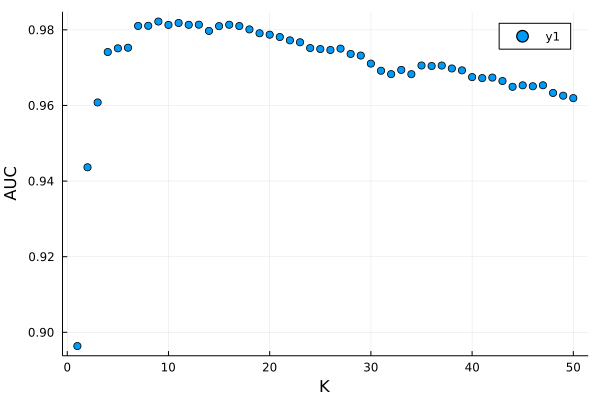

In [6]:
scatter(reshape(rep.plotting.parameter_values, :),
	    rep.plotting.measurements, xlabel = "K", ylabel = "AUC")

#### Exercise 5
With the same data as in the previous exercise, use the `MLJ` function `evaluate!` and a self tuning machine to estimate with the validation set approach the test error of kNN classifier whose hyper-parameter is tuned with 5 fold cross-validation. Use one quarter of the data for the test set.

In [7]:
self_tuning_mach.model.resampling = CV(nfolds = 5)

CV(
  nfolds = 5, 
  shuffle = false, 
  rng = Random._GLOBAL_RNG())

In [8]:
evaluate!(self_tuning_mach,
	      resampling = Holdout(fraction_train=0.75),
	      measure = auc)

PerformanceEvaluation object with these fields:
  measure, operation, measurement, per_fold,
  per_observation, fitted_params_per_fold,
  report_per_fold, train_test_rows
Extract:
┌──────────────────┬───────────┬─────────────┬──────────┐
│ measure          │ operation │ measurement │ per_fold │
├──────────────────┼───────────┼─────────────┼──────────┤
│ AreaUnderCurve() │ predict   │ 0.986       │ [0.986]  │
└──────────────────┴───────────┴─────────────┴──────────┘


#### Exercise 6
In this exercise you apply our \"recipe for supervised learning\" (see slides). The goal is to predict the miles a car can drive per gallon fuel (mpg) as a function of its horsepower. You can download a dataset with `using OpenML; cars = DataFrame(OpenML.load(455))`. In the cleaning step we will remove all rows that contain missing values (you can use the function `dropmissing`). We select the machine learning methods polynomial regression and k nearest neighbors regression and we take as measure the `rmse`. Make sure to go trough the steps 2, 5, 9 of the recipe. Plot the predictions of the best method you found. *Hint:* use `TuningModels` and the `range` function (see examples above) to tune the hyper-parameters.

In [9]:
using OpenML; cars = DataFrame(OpenML.load(455))

,name,mpg,cylinders,displacement,horsepower
,Cat…,Float64?,Cat…,Float64,Float64?
1,chevrolet_chevelle_malibu,18.0,8,307.0,130.0
2,buick_skylark_320,15.0,8,350.0,165.0
3,plymouth_satellite,18.0,8,318.0,150.0
4,amc_rebel_sst,16.0,8,304.0,150.0
5,ford_torino,17.0,8,302.0,140.0
6,ford_galaxie_500,15.0,8,429.0,198.0
7,chevrolet_impala,14.0,8,454.0,220.0
8,plymouth_fury_iii,14.0,8,440.0,215.0
9,pontiac_catalina,14.0,8,455.0,225.0


In [10]:
cars_preprocessed = dropmissing(cars)

,name,mpg,cylinders,displacement,horsepower,weight
,Cat…,Float64,Cat…,Float64,Float64,Float64
1,chevrolet_chevelle_malibu,18.0,8,307.0,130.0,3504.0
2,buick_skylark_320,15.0,8,350.0,165.0,3693.0
3,plymouth_satellite,18.0,8,318.0,150.0,3436.0
4,amc_rebel_sst,16.0,8,304.0,150.0,3433.0
5,ford_torino,17.0,8,302.0,140.0,3449.0
6,ford_galaxie_500,15.0,8,429.0,198.0,4341.0
7,chevrolet_impala,14.0,8,454.0,220.0,4354.0
8,plymouth_fury_iii,14.0,8,440.0,215.0,4312.0
9,pontiac_catalina,14.0,8,455.0,225.0,4425.0


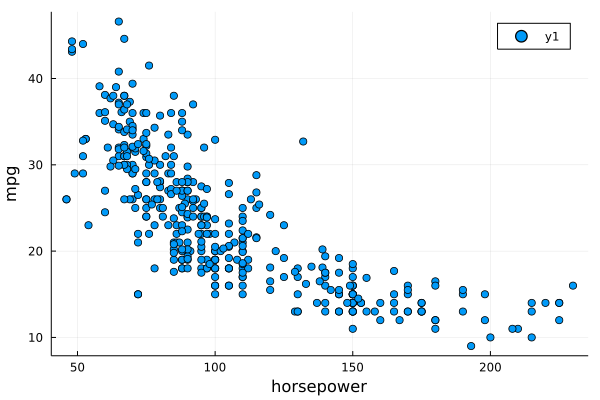

In [11]:
scatter(cars_preprocessed.horsepower, cars_preprocessed.mpg,
        xlabel = "horsepower", ylabel = "mpg")

- We can see that the mpg decreases with horsepower. This is not surprising: cars with higher horsepower are likely to use more fuel per mile; therefore the miles per gallon decreases with horsepower. The relationship looks non-linear.

- We are not interested in estimating the test error. Therefore we take all the data to perform cross-validation.

In [12]:
begin
    model2 = KNNRegressor()
    self_tuning_model2 = TunedModel(model = model2,
                                    resampling = CV(nfolds = 10, rng = 3),
                                    tuning = Grid(),
                                    range = range(model2, :K, values = 1:100),
                                    measure = rmse)
    self_tuning_mach2 = machine(self_tuning_model2,
                                select(cars_preprocessed, :horsepower),
                                cars_preprocessed.mpg)
	fit!(self_tuning_mach2, verbosity = 0)
end

trained Machine; does not cache data
  model: DeterministicTunedModel(model = KNNRegressor(K = 5, …), …)
  args: 
    1:	Source @647 ⏎ Table{AbstractVector{Continuous}}
    2:	Source @416 ⏎ AbstractVector{Continuous}


In [13]:
report(self_tuning_mach2)

(best_model = KNNRegressor(K = 48, …),
 best_history_entry = (model = KNNRegressor(K = 48, …),
                       measure = [RootMeanSquaredError()],
                       measurement = [4.292132469950239],
                       per_fold = [[4.01420761031555, 4.424903495200803, 4.357587065956705, 3.8284063177929286, 5.628056100395159, 3.7209178124472433, 4.218888847034545, 4.659478829925533, 3.379204013515204, 4.2937264785556115]],),
 history = NamedTuple{(:model, :measure, :measurement, :per_fold), Tuple{KNNRegressor, Vector{RootMeanSquaredError}, Vector{Float64}, Vector{Vector{Float64}}}}[(model = KNNRegressor(K = 91, …), measure = [RootMeanSquaredError()], measurement = [4.436019658504723], per_fold = [[4.010703749452667, 4.681577454412053, 4.562906830708155, 4.197385575002521, 5.708439796951764, 3.9660661690549808, 4.229097473004129, 4.840364385198107, 3.3754287351969388, 4.395196233515154]]), (model = KNNRegressor(K = 11, …), measure = [RootMeanSquaredError()], measurement =

In the report under `best_history_entry.measurement` we find the optimal rmse for kNN with k = (report(self_tuning_mach2).best_model.K}) to be (report(self_tuning_mach2).best_history_entry.measurement[]).

In [14]:
begin
    model3 = Polynomial() |> LinearRegressor()
    self_tuning_model3 = TunedModel(model = model3,
                                    resampling = CV(nfolds = 10, rng = 3),
                                    tuning = Grid(),
                                    range = range(model3, :(polynomial.degree),
                                                  values = 1:8),
                                    measure = rmse)
    self_tuning_mach3 = machine(self_tuning_model3,
                                select(cars_preprocessed, :horsepower),
                                cars_preprocessed.mpg) |> fit!
end

┌ Info: Training machine(DeterministicTunedModel(model = DeterministicPipeline(polynomial = Polynomial(degree = 3, …), …), …), …).
└ @ MLJBase /Users/simonlee/.julia/packages/MLJBase/kihuj/src/machines.jl:496
┌ Info: Attempting to evaluate 8 models.
└ @ MLJTuning /Users/simonlee/.julia/packages/MLJTuning/eSEHt/src/tuned_models.jl:727
Evaluating over 8 metamodels: 100%[=========================] Time: 0:00:12


trained Machine; does not cache data
  model: DeterministicTunedModel(model = DeterministicPipeline(polynomial = Polynomial(degree = 3, …), …), …)
  args: 
    1:	Source @649 ⏎ Table{AbstractVector{Continuous}}
    2:	Source @648 ⏎ AbstractVector{Continuous}


In [15]:
report(self_tuning_mach3)

(best_model = DeterministicPipeline(polynomial = Polynomial(degree = 5, …), …),
 best_history_entry = (model = DeterministicPipeline(polynomial = Polynomial(degree = 5, …), …),
                       measure = [RootMeanSquaredError()],
                       measurement = [4.353384111251641],
                       per_fold = [[4.110053887467352, 4.5765037782996005, 4.376726257040189, 3.905405160492514, 5.769493205587982, 3.736247139681804, 4.1817005919317545, 4.764317652483827, 3.465315914530316, 4.223071009787187]],),
 history = NamedTuple{(:model, :measure, :measurement, :per_fold), Tuple{MLJBase.DeterministicPipeline{NamedTuple{(:polynomial, :linear_regressor), Tuple{Static, Deterministic}}, MLJModelInterface.predict}, Vector{RootMeanSquaredError}, Vector{Float64}, Vector{Vector{Float64}}}}[(model = DeterministicPipeline(polynomial = Polynomial(degree = 2, …), …), measure = [RootMeanSquaredError()], measurement = [4.384933654665197], per_fold = [[4.137977793298697, 4.58285923099681

For polynomial regression we find the best model for d = (report(self_tuning_mach3).best_model.polynomial.degree) at loss (report(self_tuning_mach3).best_history_entry.measurement[]). kNN with k = (report(self_tuning_mach2).best_model.K) had a slightly lower error of (report(self_tuning_mach2).best_history_entry.measurement[]) than polynomial regression with (report(self_tuning_mach3).best_model.polynomial.degree) degrees. We refit therefore the kNN model on all the data.

In [16]:
best_mach = machine(KNNRegressor(K = report(self_tuning_mach2).best_model.K),
	                select(cars_preprocessed, :horsepower),
	                cars_preprocessed.mpg) |> fit!

┌ Info: Training machine(KNNRegressor(K = 48, …), …).
└ @ MLJBase /Users/simonlee/.julia/packages/MLJBase/kihuj/src/machines.jl:496


trained Machine; caches model-specific representations of data
  model: KNNRegressor(K = 48, …)
  args: 
    1:	Source @922 ⏎ Table{AbstractVector{Continuous}}
    2:	Source @435 ⏎ AbstractVector{Continuous}


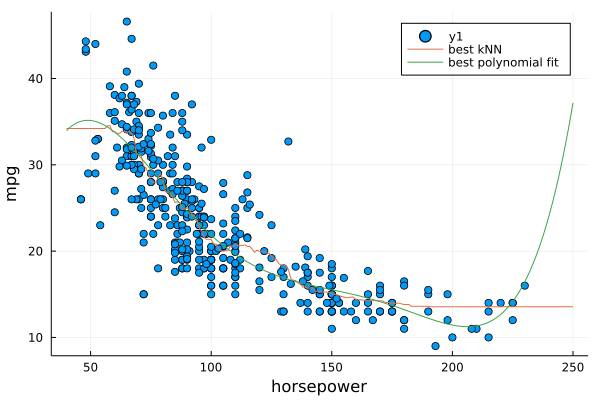

In [17]:
let
    scatter(cars_preprocessed.horsepower, cars_preprocessed.mpg,
            xlabel = "horsepower", ylabel = "mpg")
    data_test = DataFrame(horsepower = 40:250)
    pred_best = predict(best_mach, data_test)
    pred_poly = predict(self_tuning_mach3, data_test)
    plot!(40:250, pred_best, label = "best kNN")
    plot!(40:250, pred_poly, label = "best polynomial fit")
end

Given the wiggliness of the best kNN solution, it may be that it still overfits the data slightly. If we would want to be sure, we would need to collect more data.

In [18]:
multi_model = TunedModel(models=[report(self_tuning_mach2).best_model,
	                             report(self_tuning_mach3).best_model],
						 resampling=CV(nfolds=6),
						 measure=rmse)

DeterministicTunedModel(
  model = KNNRegressor(
        K = 48, 
        algorithm = :kdtree, 
        metric = Euclidean(0.0), 
        leafsize = 10, 
        reorder = true, 
        weights = Uniform()), 
  tuning = Explicit(), 
  resampling = CV(
        nfolds = 6, 
        shuffle = false, 
        rng = Random._GLOBAL_RNG()), 
  measure = RootMeanSquaredError(), 
  weights = nothing, 
  class_weights = nothing, 
  operation = nothing, 
  range = Deterministic[KNNRegressor(K = 48, …), DeterministicPipeline(polynomial = Polynomial(degree = 5, …), …)], 
  selection_heuristic = MLJTuning.NaiveSelection(nothing), 
  train_best = true, 
  repeats = 1, 
  n = nothing, 
  acceleration = CPU1{Nothing}(nothing), 
  acceleration_resampling = CPU1{Nothing}(nothing), 
  check_measure = true, 
  cache = true)

In [19]:
mm = fit!(machine(multi_model, select(cars_preprocessed, :horsepower),
	         cars_preprocessed.mpg))

┌ Info: Training machine(DeterministicTunedModel(model = KNNRegressor(K = 48, …), …), …).
└ @ MLJBase /Users/simonlee/.julia/packages/MLJBase/kihuj/src/machines.jl:496
┌ Info: Attempting to evaluate 2 models.
└ @ MLJTuning /Users/simonlee/.julia/packages/MLJTuning/eSEHt/src/tuned_models.jl:727
Evaluating over 2 metamodels: 100%[=========================] Time: 0:00:00


trained Machine; does not cache data
  model: DeterministicTunedModel(model = KNNRegressor(K = 48, …), …)
  args: 
    1:	Source @369 ⏎ Table{AbstractVector{Continuous}}
    2:	Source @965 ⏎ AbstractVector{Continuous}


In [20]:
report(mm)

(best_model = KNNRegressor(K = 48, …),
 best_history_entry = (model = KNNRegressor(K = 48, …),
                       measure = [RootMeanSquaredError()],
                       measurement = [4.6734130490337975],
                       per_fold = [[3.5585807399708402, 3.9155919352760034, 4.483012109000427, 3.5098068975086285, 5.237539764347346, 6.57277835199264]],),
 history = NamedTuple{(:model, :measure, :measurement, :per_fold)}[(model = KNNRegressor(K = 48, …), measure = [RootMeanSquaredError()], measurement = [4.6734130490337975], per_fold = [[3.5585807399708402, 3.9155919352760034, 4.483012109000427, 3.5098068975086285, 5.237539764347346, 6.57277835199264]]), (model = DeterministicPipeline(polynomial = Polynomial(degree = 5, …), …), measure = [RootMeanSquaredError()], measurement = [4.705452819428962], per_fold = [[3.755489853461521, 4.090695700061408, 4.522509021004197, 3.4868541783070133, 5.355548980723369, 6.380993439466142]])],
 best_report = (),)

In [21]:
e = evaluate(multi_model,
	         select(cars_preprocessed, :horsepower),
	         cars_preprocessed.mpg,
			 resampling=CV(nfolds=6),
			 measure=rmse,
			 verbosity=0)

PerformanceEvaluation object with these fields:
  measure, operation, measurement, per_fold,
  per_observation, fitted_params_per_fold,
  report_per_fold, train_test_rows
Extract:
┌────────────────────────┬───────────┬─────────────┬─────────┬──────────────────
│ measure                │ operation │ measurement │ 1.96*SE │ per_fold        ⋯
├────────────────────────┼───────────┼─────────────┼─────────┼──────────────────
│ RootMeanSquaredError() │ predict   │ 4.65        │ 1.0     │ [3.56, 3.92, 4. ⋯
└────────────────────────┴───────────┴─────────────┴─────────┴──────────────────
                                                                1 column omitted


In [22]:
e.report_per_fold

6-element Vector{NamedTuple{(:best_model, :best_history_entry, :history, :best_report)}}:
 (best_model = KNNRegressor(K = 48, …), best_history_entry = (model = KNNRegressor(K = 48, …), measure = [RootMeanSquaredError()], measurement = [4.95555931835202], per_fold = [[4.644346956138173, 5.042532459155959, 3.455025703319255, 3.379596730560318, 6.471916930190468, 5.924840189617367]]), history = NamedTuple{(:model, :measure, :measurement, :per_fold)}[(model = KNNRegressor(K = 48, …), measure = [RootMeanSquaredError()], measurement = [4.95555931835202], per_fold = [[4.644346956138173, 5.042532459155959, 3.455025703319255, 3.379596730560318, 6.471916930190468, 5.924840189617367]]), (model = DeterministicPipeline(polynomial = Polynomial(degree = 5, …), …), measure = [RootMeanSquaredError()], measurement = [6.297835455272933], per_fold = [[10.774348520695051, 4.954389420604907, 3.675643699149872, 3.2404880019026847, 6.382366401528575, 5.709475280340152]])], best_report = NamedTuple())
 (best_m